## Imports & check GPU

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

In [2]:
torch.manual_seed(69)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 128
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [5]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [6]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [7]:
root = 'real_easy_and_mid'
train_easy, test_easy, val_easy = create_subsets(root, transformation)
train_loader_easy, test_loader_easy, valid_loader_easy = produce_loaders(train_easy, test_easy, val_easy)

In [8]:
root = 'real_and_hard'
train_hard, test_hard, val_hard = create_subsets(root, transformation)
train_loader_hard, test_loader_hard, valid_loader_hard = produce_loaders(train_hard, test_hard, val_hard)

In [9]:
def visualize_data(dataset, figsize=(8,8), axes=3):
    indices = []
    labels_map = {
        0: "fake",
        1: "real",
    }
    cols, rows = axes, axes
    figure = plt.figure(figsize=figsize)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        indices.append(sample_idx)
        img, label = dataset[sample_idx]
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img)
    print(indices)
    indices = []
    plt.show()

[247, 293, 1069, 273, 567, 1197, 980, 378, 429]


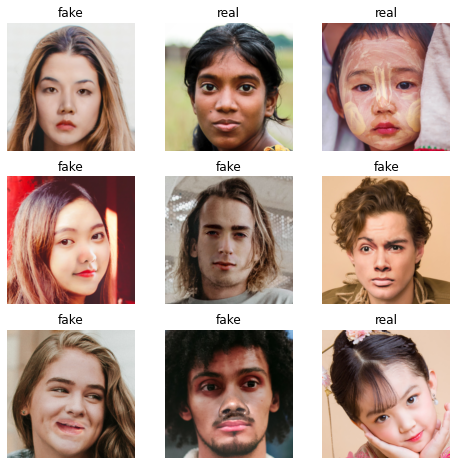

In [10]:
visualize_data(train_easy)

[270, 209, 251, 391, 352, 18, 401, 369, 295]


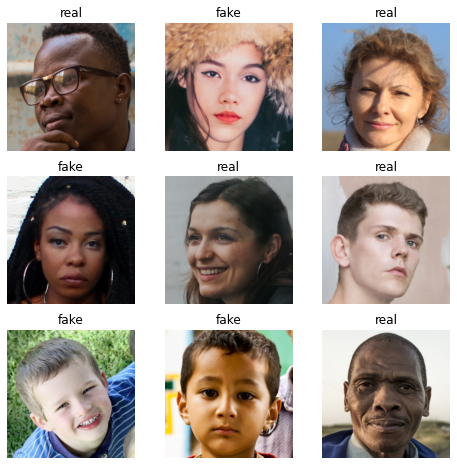

In [11]:
visualize_data(train_hard)

## Define Model

In [13]:
class DeepSearchConv(torch.nn.Module):
    def __init__(self, inputs, outputs, kernel = 3):
        super(DeepSearchConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel)
        self.dropout = nn.Dropout2d(0.25)
        self.batch_norm = nn.BatchNorm2d(outputs)
        
    def forward(self, x):
        x = self.conv(x)
        x = F.leaky_relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x

In [14]:
class DeepSearchDownsize(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchDownsize, self).__init__()
        
        self.avgpool = nn.AvgPool2d(2)
        self.linear = nn.Linear(inputs, outputs)
        self.inputs = inputs
        
    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(-1, self.inputs)
        x = self.linear(x)
        return x

In [15]:
class DeepSearchLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepSearchLinear, self).__init__()
        
        self.batch_norm = nn.BatchNorm1d(inputs)
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(inputs, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [16]:
class DeepSearch(torch.nn.Module):
    def __init__(self, hidden, flattened, linear, labels):
        super(DeepSearch, self).__init__()
        
        self.conv = [ DeepSearchConv( hidden[i], hidden[i+1] ) for i in range(len(hidden)-1) ]
        self.downsize = DeepSearchDownsize(flattened, linear)
        self.output = DeepSearchLinear(linear, labels)
        
        self.combined = nn.Sequential(*self.conv,
                                     self.downsize,
                                     self.output)
    
    def forward(self, x):
        x = self.combined(x)
        return x

In [17]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [18]:
from math import floor
hidden = [3, 32, 32]
channels = hidden[-1]
changed_img = floor((size-2*(len(hidden)-1))/2)
linear = 128
labels = 2
flattened = channels*changed_img*changed_img

In [19]:
model = DeepSearch(hidden=hidden, flattened=flattened, linear=linear, labels=labels).to(device)
optimizer = create_adam_optimizer(model, lr = 0.05, amsgrad=True)

## Train Model

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

In [23]:
def test(model, data_loader, criterion):
    # Use cross-entropy loss function
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    correct = 0
    total = 0
    # Iterate over test data
    for inputs, labels in data_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc = correct/total
    return epoch_loss, epoch_acc

In [37]:
def train(model, train_loader, valid_loader, test_loader, optimizer, epochs = 1):
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            if (batch_number%3==0):
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Validation set
        epoch_loss, epoch_acc = test(model, valid_loader, criterion)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Val loss: {epoch_loss:.4f}, Val accuracy: {epoch_acc:.4f}')
    
    # Test set
    epoch_loss, epoch_acc = test(model, test_loader, criterion)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)
    print(f'Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')

In [47]:
for i in range(5):
    print(f'Pass {i}')
    train(model, train_loader_easy, valid_loader_easy, test_loader_easy, optimizer = optimizer)
    train(model, train_loader_hard, valid_loader_hard, test_loader_hard, optimizer = optimizer)

Pass 0
Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.6015625
Epoch 1/1, Batch number: 3, Cumulated accuracy: 0.58984375
Epoch 1/1, Batch number: 6, Cumulated accuracy: 0.5970982142857143
Epoch 1/1, Batch number: 9, Cumulated accuracy: 0.6069941715237303
--- Epoch 1/1: Train loss: 0.6567, Train accuracy: 0.6070
--- Epoch 1/1: Val loss: 0.6496, Val accuracy: 0.5467
Test loss: 0.6071, Test accuracy: 0.5733
Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.625
Epoch 1/1, Batch number: 3, Cumulated accuracy: 0.5995370370370371
--- Epoch 1/1: Train loss: 0.6541, Train accuracy: 0.5995
--- Epoch 1/1: Val loss: 0.6760, Val accuracy: 0.6667
Test loss: 0.6021, Test accuracy: 0.6852
Pass 1
Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.6171875
Epoch 1/1, Batch number: 3, Cumulated accuracy: 0.626953125
Epoch 1/1, Batch number: 6, Cumulated accuracy: 0.6261160714285714
Epoch 1/1, Batch number: 9, Cumulated accuracy: 0.6153205661948377
--- Epoch 1/1: Train loss: 0.6512, Train accuracy: 0.615

In [48]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './first_model')

## Test Model (on entire dataset)

In [26]:
transformation2 = Compose([Resize((size, size)), ToTensor()])

In [27]:
entire_dataset_easy = ImageFolder('real_easy_and_mid', transformation2)
entire_dataset_hard = ImageFolder('real_and_hard', transformation2)

In [28]:
entire_dataset = torch.utils.data.ConcatDataset([ entire_dataset_easy, entire_dataset_hard ])
full_loader = torch.utils.data.DataLoader(entire_dataset, batch_size = 1, shuffle = False)

In [29]:
model_test = DeepSearch(hidden=hidden, flattened=flattened, linear=linear, labels=labels).to(device)
optimizer_test = create_adam_optimizer(model_test, lr = 0.05, amsgrad=True)

In [57]:
checkpoint = torch.load('./first_model')
model_test.load_state_dict(checkpoint['model_state_dict'])
optimizer_test.load_state_dict(checkpoint['optimizer_state_dict'])

In [33]:
def test_visual(model, data_loader, criterion):
    correct_list = []
    wrong_list = []
    # Use cross-entropy loss function
    model.eval()
    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    correct = 0
    total = 0
    # Iterate over test data
    for inputs, labels in data_loader:
        # Get from dataloader and send to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Compute model output and loss
        # (No grad computation here, as it is the test data)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        # Accumulate loss and correct predictions for epoch
        epoch_loss += loss.item()
        total += labels.size(0)
        
        if (predicted.item() == labels.item()):
            correct_list.append( (inputs.squeeze().detach().cpu().numpy(), labels.item()) )
        else:
            wrong_list.append( (inputs.squeeze().detach().cpu().numpy(), labels.item()) )
            
        correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
    epoch_loss /= len(data_loader)
    epoch_acc = correct/total
    print(f'Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    return correct_list, wrong_list, epoch_loss, epoch_acc

In [58]:
criterion = nn.CrossEntropyLoss()
correct_list, wrong_list, full_test_loss, full_test_acc = test_visual(model_test, full_loader, criterion)

Test loss: 0.6255, Test accuracy: 0.6605


## Correct Predictions

[449, 917, 907, 790, 624, 996, 853, 272, 207, 728, 523, 1180, 482, 288, 151, 904, 1062, 1031, 1241, 206, 664, 1091, 363, 259, 112]


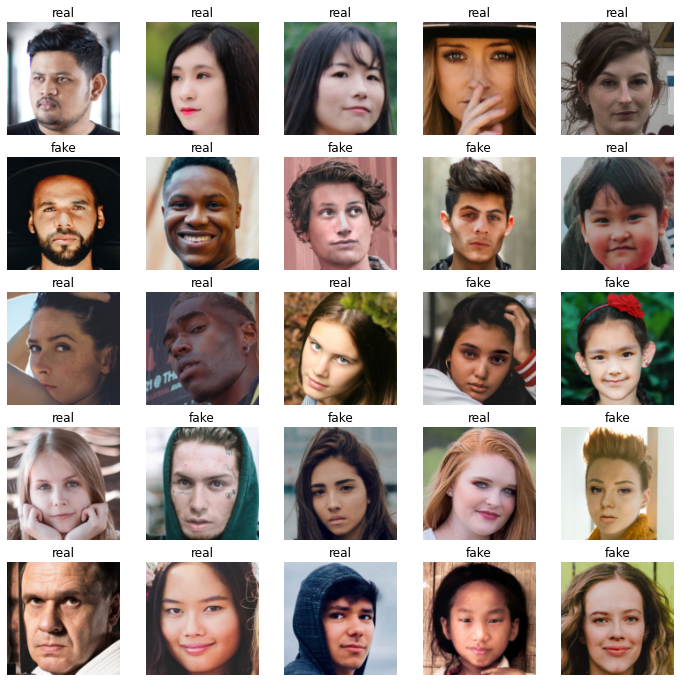

In [59]:
visualize_data(correct_list, (12, 12), 5)

## Wrong Predictions

[128, 257, 104, 675, 506, 49, 191, 618, 107, 206, 589, 177, 597, 313, 508, 643, 355, 540, 518, 381, 620, 356, 167, 502, 367]


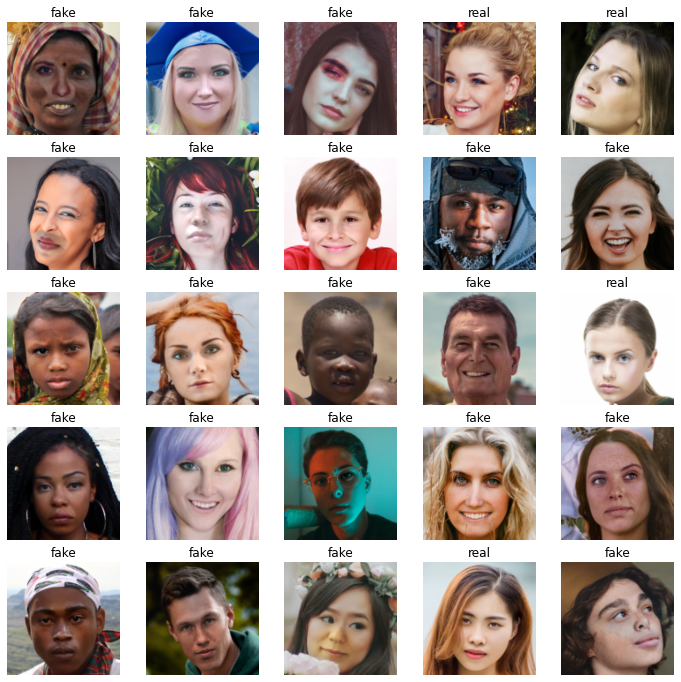

In [60]:
visualize_data(wrong_list, (12, 12), 5)

## Performance Metrics

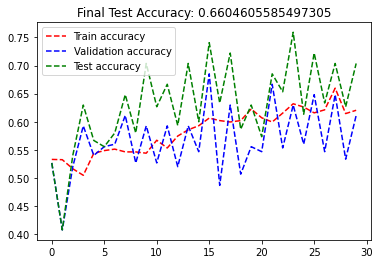

In [61]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.plot(test_accuracies, "g--", label='Test accuracy')
plt.title("Final Test Accuracy: {}".format(full_test_acc))
plt.legend(loc='upper left')
plt.show()

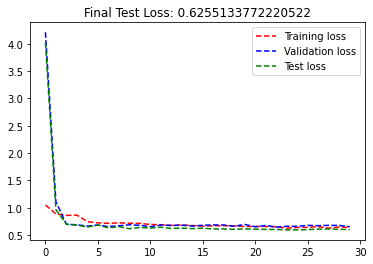

In [62]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.plot(test_losses, "g--", label='Test loss')
plt.title("Final Test Loss: {}".format(full_test_loss))
plt.legend(loc='upper right')
plt.show()